In [ ]:
from envs.blackjack_env import BlackjackEnv
from poker_cards import CARD_DECK, CARD_VALUES
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gymnasium as gym

In [42]:
## Initialize 
n_decks = 1
env = BlackjackEnv()
Q = np.zeros((32, 2, 12, env.action_space.n)) # 32 possible hand values, usable ace bool, 12 possible dealer card
gamma = 1 # discount factor = no discount
epsilon_decay = 0.995
min_epsilon = 0.05

In [43]:
# Model Diagnostic and Fine-tuning
visit_counts = np.zeros(Q.shape[:-1], dtype = np.int32)

In [44]:
## Training Loop Functions
def update_q_table(state, action, reward, next_state, terminated, alpha): # state is a dict
    # extract and unpack obs
    a, b, c = list(state.values())          # own_hand_value, usable_ace, dealer_upcard
    na, nb, nc = list(next_state.values())

    # update table
    old_value = Q[a, b, c, action]
    next_max = max(Q[na, nb, nc]) if not terminated else 0
    Q[a, b, c, action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

def epsilon_greedy(state, epsilon):
    # implement the condition to explore
    if np.random.rand() <= epsilon:
      	# choose a random action
        action = env.action_space.sample()
    else:
      	# choose the best action according to Q
        a, b, c = list(state.values())
        action = np.argmax(Q[a, b, c])
    return action

def q_learning(n_episodes, epsilon, alpha):
    ## Training loop
    bundled_episode_returns = []
    bundle_return = 0

    for episode in range(n_episodes):
        state, info = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False

        while not (terminated or truncated):
            # diagnostics
            a, b, c = list(state.values())
            visit_counts[a, b, c] += 1

            action = epsilon_greedy(state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)
            update_q_table(state, action, reward, new_state, terminated or truncated, alpha)
            state = new_state
            episode_reward += reward

        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        bundle_return += episode_reward
        if (episode + 1) % 1000 == 0:
            bundled_episode_returns.append(bundle_return / 1000)
            bundle_return = 0

    return bundled_episode_returns

In [45]:
# Training
episode_returns_1 = q_learning(200000, 1, 0.1) # first round, initial epsilon of 1
episode_returns_2 = q_learning(200000, 0.5, 0.05) # second round, initial eps of 0.5, 0.05 lr
episode_returns_3 = q_learning(200000, 0.3, 0.02) # third round, fine tune

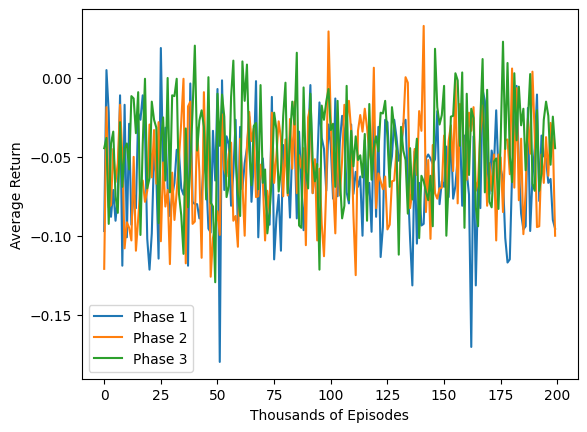

In [39]:
# Sanity Check - but doesnt rly show much tbh
plt.plot(episode_returns_1, label = 'Phase 1')
plt.plot(episode_returns_2, label = 'Phase 2')
plt.plot(episode_returns_3, label = 'Phase 3')
plt.xlabel('Thousands of Episodes')
plt.ylabel('Average Return')
plt.legend()
plt.show() 

In [ ]:
# Diagnostics and retraining
a,b = player_value, usable_ace
for dealer in range(1,11):
    print(dealer, visit_counts[a,b,dealer])

In [ ]:
def print_policy(Q):
    for usable_ace in [0, 1]:
        print(f"\nUsable Ace = {usable_ace}")
        print("Player↓ | Dealer→")
        print("           2 3 4 5 6 7 8 9 10 A")
        print("-" * 40)
        for player_value in range(1, 22):
            row = f"{player_value:>3}      | "
            for dealer_up in range(10):  # index 0 to 9
                action = np.argmax(Q[player_value, usable_ace, dealer_up])
                symbol = "H" if action == 1 else "S"
                row += symbol + " "
            print(row)

print_policy(Q)


Usable Ace = 0
Player↓ | Dealer→
           2 3 4 5 6 7 8 9 10 A
----------------------------------------
  1      | S S S S S S S S S S 
  2      | S S S S S S S S S S 
  3      | S S S S S S S S S S 
  4      | S S H H H H H H H H 
  5      | S S H H H H H H H H 
  6      | S S H H H H H H H H 
  7      | S S H H H H H H H H 
  8      | S S H H H H H H H H 
  9      | S S H H H H H H H H 
 10      | S S H H H H H H H H 
 11      | S S H H H H H H H H 
 12      | S S H H H S H H H H 
 13      | S S H S S S S H H H 
 14      | S S S S H S S H H H 
 15      | S S H S S S S H H H 
 16      | S S S S S S S H H H 
 17      | S S S S S S S S S S 
 18      | S S S S S S S S S S 
 19      | S S S S S S S S S S 
 20      | S S S S S S S S S S 
 21      | S S S S S S S S S S 

Usable Ace = 1
Player↓ | Dealer→
           2 3 4 5 6 7 8 9 10 A
----------------------------------------
  1      | S S S S S S S S S S 
  2      | S S S S S S S S S S 
  3      | S S S S S S S S S S 
  4      | S S S S

In [41]:
## Comparison

n_episodes = 100000

def trained_policy(Q):
    episode_returns = 0

    for episode in range(n_episodes):
        state, info = env.reset()
        episode_reward = 0
        terminated = False

        while not terminated:
            own_hand_value, usable_ace, dealer_upcard = list(state.values())
            action = np.argmax(Q[own_hand_value, usable_ace, dealer_upcard])
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state

        episode_returns += reward
    
    return episode_returns / n_episodes

def random_policy():
    episode_returns = 0

    for episode in range(n_episodes):
        state, info = env.reset()
        episode_reward = 0
        terminated = False

        while not terminated:
            own_hand_value, usable_ace, dealer_upcard = list(state.values())
            action = env.action_space.sample()
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state

        episode_returns += reward
    
    return episode_returns / n_episodes

trained_returns = trained_policy(Q)
random_returns = random_policy()

print(trained_returns, random_returns)

-0.024485 -0.376925
